Tasks:
* Create cronjob
* Web scrapping
* Download zip file
* Unzip it
* Read file which name start with "lotto_"

Preparation:
* Read file
* Extract columns 'boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5', 'numero_chance', year
* Set custom range of rows (slider or input), predefine ranges - last 50, all, etc.

Analysis:
* Odd / Even - (3 odd + 2 even - 814 times)
* Define patterns: (1-9 - blue, 10-19 - yellow, etc) occurencies (by year) count and PROBABILITY https://lottometrix.com/members/analysis-euromillions.php
* Top Hot - most occurencies in row range
* Top Cold - less occurencies on row range
* Overdue - Number which isn't drawn for a long time (show be beyond range)
* Pairs and frequency (2,14 - 5 times)
* Sum and frequency (sum of all numbers: 132 - 56 times)
* Low / High - split on 24(or 25) occurencies - (3 low, 2 high - 529 times)
* Consecutives (0 - 1144 times, 1 - 311 times)
* Regularity (each number is + 7) or (+7 +8 + 9 etc)
* Following numbers
* Non following numbers
* Average numbers
* Heat map chart

AI:
* Split analysis on two groups: probability and history. Set each of them value. History value should be lesser than prob one

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Web scrapping
import requests
import zipfile
import os

def download_and_extract_zip(url, destination_folder):
    # Step 1: Download the zip file
    response = requests.get(url)
    
    if response.status_code == 200:
        # Step 2: Save the zip file locally
        zip_filename = "downloaded_file.zip"
        with open(zip_filename, 'wb') as f:
            f.write(response.content)

        # Step 3: Extract the contents of the zip file
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(destination_folder)

        # Step 4: Delete the zip file
        os.remove(zip_filename)
        print(f"Downloaded and extracted successfully to {destination_folder}")
    else:
        print(f"Failed to download the file. HTTP status code: {response.status_code}")

# Example usage
url_to_zip = "https://www.sto.api.fdj.fr/anonymous/service-draw-info/v3/documentations/1a2b3c4d-9876-4562-b3fc-2c963f66afp6"
download_destination = "./"

download_and_extract_zip(url_to_zip, download_destination)

Downloaded and extracted successfully to ./


In [4]:
file_name = "loto_201911.csv"
# Create a DataFrame with all possible numbers from 1 to 49
all_numbers = pd.DataFrame({'number': range(1, 50)})

In [5]:
df = pd.read_csv(file_name, sep=";")

In [6]:
df = df[['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5', 'numero_chance', 'date_de_tirage']]

In [7]:
df.head(20)

,boule_1,boule_2,boule_3,boule_4,boule_5,numero_chance,date_de_tirage
0,9,21,24,30,28,9,07/12/2024
1,40,21,7,34,3,1,04/12/2024
2,48,16,22,41,4,10,02/12/2024
3,21,4,10,38,19,1,30/11/2024
4,15,7,31,35,20,6,27/11/2024
5,13,7,37,49,3,5,25/11/2024
6,37,33,36,34,20,2,23/11/2024
7,35,37,45,48,27,5,20/11/2024
8,17,12,3,8,6,9,18/11/2024
9,46,5,29,7,19,4,16/11/2024


In [8]:
range_col = df['numero_chance']

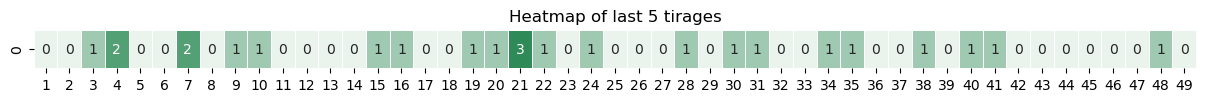

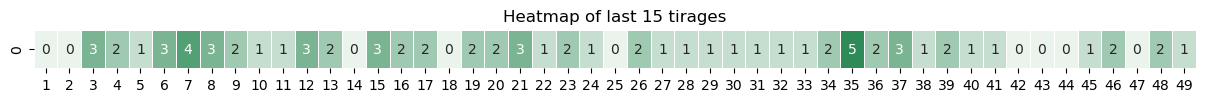

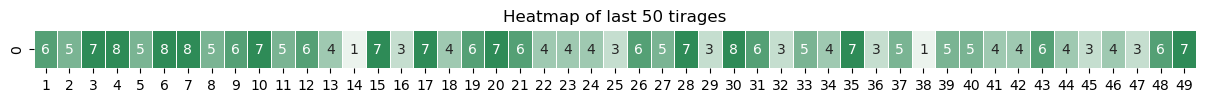

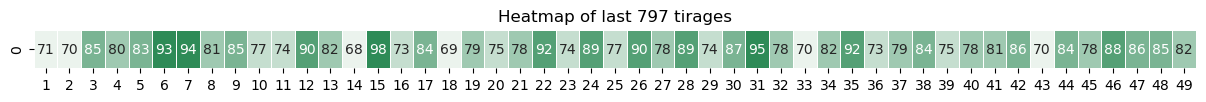

In [9]:
# HEATMAP
def exctract_data_frame(data_frame, first_n_rows=None):
    if first_n_rows is None:
        return data_frame.copy()  # Return a copy of the entire DataFrame
    else:
        return data_frame.truncate(before=0, after=first_n_rows - 1) # starts from 0
    

def show_heat_map(last_tirages=None):
    extracted_df = exctract_data_frame(df, last_tirages)
    # print(extracted_df.head())
    
    # Reshape the DataFrame to a single column
    flat_df = pd.melt(extracted_df, value_vars=['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5'],
                      var_name='boule', value_name='number')
    # print(f'Melt:\n{flat_df}')
    
    tirages_count = int(len(flat_df) / 5)

    # Create a pivot table to count the occurrences of each number
    heatmap_data = flat_df.pivot_table(index='number', aggfunc='size', fill_value=0)
    # print(f'Pivot:\n {heatmap_data}')
    
    # Add missing values from 1 to 49 with a count of 0
    heatmap_data = heatmap_data.reindex(index=range(1, 50), fill_value=0)
    # print(f'Pivot 2:\n {heatmap_data}')

    # Get the numbers as the x-axis labels
    numbers = heatmap_data.index
    # print(numbers)

    # Reshape the DataFrame to a 1D array
    heatmap_data = heatmap_data.values

    # Create a heatmap
    plt.figure(figsize=(15, 0.5))
    # print(heatmap_data.reshape(1, -1))
    sns.heatmap(heatmap_data.reshape(1, -1), cmap=sns.light_palette("seagreen"), annot=True, fmt='d', linewidths=.5, cbar=False,
                xticklabels=numbers)
    plt.title(f'Heatmap of last {tirages_count} tirages')
    plt.show()
    # sns.barplot(data=None, x=numbers, y=heatmap_data, width=1, fill=True)

    
show_heat_map(5)
show_heat_map(15)
show_heat_map(50)
show_heat_map()

In [10]:
# PATTERNS
dfp = pd.DataFrame(df, columns=['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5']) # TODO add the date
# print(dfp.head())

# Sort the values within each row in ascending order
sorted_df = dfp.apply(lambda row: pd.Series(row.sort_values().values), axis=1)
# print(sorted_df.head())

# Define a function to categorize a number
def categorize_number(number):
    if 1 <= number <= 10:
        return 'green'
    elif 11 <= number <= 20:
        return 'yellow'
    elif 21 <= number <= 30:
        return 'red'
    elif 31 <= number <= 40:
        return 'purple'
    elif 41 <= number <= 49:
        return 'blue'
    else:
        return 'Out of range'

# Apply the categorization function to each element in the DataFrame
categorized_df = sorted_df.apply(lambda col: col.map(categorize_number))

# Join the results to create a 'Pattern' column for each row
categorized_df['Pattern'] = categorized_df.apply(lambda row: '-'.join(row), axis=1)

# Display the result
print(categorized_df.head(20))

# Count occurrences of each unique pattern
pattern_counts = categorized_df['Pattern'].value_counts()

first_n_counts = categorized_df.head(20)['Pattern']
print(first_n_counts)

# Display the result
print(pattern_counts)

         0       1       2       3       4                             Pattern
0    green     red     red     red     red               green-red-red-red-red
1    green   green     red  purple  purple       green-green-red-purple-purple
2    green  yellow     red    blue    blue          green-yellow-red-blue-blue
3    green   green  yellow     red  purple       green-green-yellow-red-purple
4    green  yellow  yellow  purple  purple   green-yellow-yellow-purple-purple
5    green   green  yellow  purple    blue      green-green-yellow-purple-blue
6   yellow  purple  purple  purple  purple  yellow-purple-purple-purple-purple
7      red  purple  purple    blue    blue         red-purple-purple-blue-blue
8    green   green   green  yellow  yellow     green-green-green-yellow-yellow
9    green   green  yellow     red    blue         green-green-yellow-red-blue
10   green  yellow  yellow  purple  purple   green-yellow-yellow-purple-purple
11   green   green  yellow  purple    blue      gree

Legend:


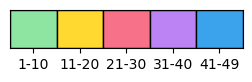

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Set the size of the plot
fig, ax = plt.subplots(figsize=(3, 0.5))  # Width: 2 inches, Height: 0.7 inches

# Define the number of rectangles
num_rectangles = 5

# Define the starting point and size of the first rectangle
x, y = 0.0, 0.0
width, height = 1.0, 1.0

# Color names for each rectangle
colors = ['#8de5a1', '#ffd92f', '#f77189', '#bb83f4', '#3ba3ec']

# Create and display rectangles with different colors
for i in range(num_rectangles):
    color = colors[i]
    rectangle = patches.Rectangle((x, y), width, height, edgecolor='black', facecolor=color)
    ax.add_patch(rectangle)
    x += width  # Move to the next position

# Remove x-axis and y-axis labels
ax.set_xticks([width * i + width/2 for i in range(num_rectangles)])
ax.set_yticks([])
ax.set_xticklabels(['1-10', '11-20', '21-30', '31-40', '41-49'])
ax.set_ylabel('')

# Set axis limits
ax.set_xlim(0, num_rectangles * width)
ax.set_ylim(0, height)

# Display the plot
print("Legend:")
plt.show()

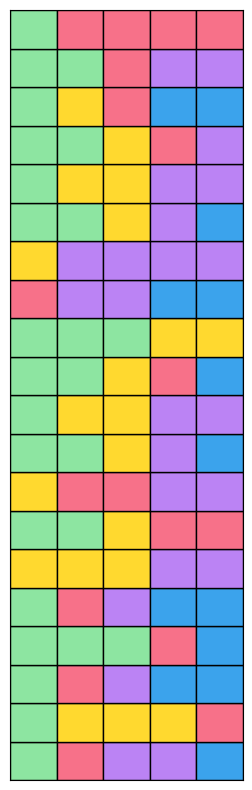

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

class PatternPlotter:
    def __init__(self, df):
        self.df = df
        self.color_mapping = {'green': 0, 'yellow': 1, 'red': 2, 'purple': 3, 'blue': 4}
        self.colors = ['#8de5a1', '#ffd92f', '#f77189', '#bb83f4', '#3ba3ec']

    def plot_patterns(self):
        fig, ax = plt.subplots(figsize=(3, len(self.df) / 2))

        for index, row in self.df[::-1].iterrows():
            pattern_colors = row['Pattern'].split('-')
            rectangles = [patches.Rectangle((i, len(self.df) - index - 1), 1, 1, edgecolor='black', facecolor=self.colors[self.color_mapping[color]]) for i, color in enumerate(pattern_colors)]
            for rectangle in rectangles:
                ax.add_patch(rectangle)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xlim(0, len(pattern_colors))
        ax.set_ylim(0, len(self.df))

        plt.show()

data = {
    'Pattern': first_n_counts
}

df = pd.DataFrame(data)
plotter = PatternPlotter(df)
plotter.plot_patterns()

Test Set Accuracy: 0.44
Predicted patter for next draw:


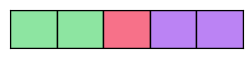

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import joblib

import numpy as np
import pandas as pd

# Your historical data
data = {
    'Pattern': categorized_df['Pattern'].values
}

df = pd.DataFrame(data)

# Convert color names to numerical values for training the classifier
color_mapping = {'green': 0, 'yellow': 1, 'red': 2, 'purple': 3, 'blue': 4}

df['PatternEncoded'] = df['Pattern'].apply(lambda x: [color_mapping[color] for color in x.split('-')])

# # Split the data into features (X) and target (y)
X = df['PatternEncoded'].iloc[:-1].tolist()  # Use all rows except the last one as features
y = df['PatternEncoded'].shift(-1).dropna().tolist()  # Shift the target by one row to predict the next row

# # Assuming X is your feature matrix, and y is the list of lists representing labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Create and train the Decision Tree Classifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

#Store model
joblib.dump(clf, 'pattern-oracle.joblib')
# clf = joblib.load('pattern-oracle.joblib')

# Extract features from the first row of your data
first_row_features = np.array(df['PatternEncoded'].iloc[0])

# Reshape the features array to match the expected input shape of the classifier
first_row_features = first_row_features.reshape(1, -1)

# Assuming X_test is your test feature matrix
# Assuming y_test is the true labels for the test set
y_pred_test = clf.predict(X_test)

# Flatten the predicted and true labels
y_pred_test_flat = [item for sublist in y_pred_test for item in sublist]
y_test_flat = [item for sublist in y_test for item in sublist]

# Calculate accuracy
accuracy = accuracy_score(y_test_flat, y_pred_test_flat)
print(f'Test Set Accuracy: {accuracy}')

# Make prediction
predicted_item = clf.predict(first_row_features)
color_names = np.vectorize(lambda x: list(color_mapping.keys())[list(color_mapping.values()).index(int(x))])(predicted_item[0])
color_names = ('-').join(color_names)
print("Predicted patter for next draw:")

data = {'Pattern': [color_names]}
df = pd.DataFrame(data)
plotter = PatternPlotter(df)
plotter.plot_patterns()